In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *

import phate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# symsim_r1b1 = endoRNA_noIAC(standardize=False)
# symsim_r1b2 = endoATAC_noIAC(standardize=False)
symsim_r1b1 = endoRNA(standardize=False)
symsim_r1b2 = endoATAC(standardize=False)

symsim_r1b1_CONFIG = { 
    'in_features': 500,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

symsim_r1b2_CONFIG = { 
    'in_features': 128,
    'layers': [256, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}


train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_r1b1_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_r1b2_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    U_t1, Diff1 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 10, 
                                  t = 20, 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 40)

    Diff1 = torch.FloatTensor(Diff1).to(device)
    # X_phate1 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())
    


for data in test_r1b2_loader:
    U_t2, Diff2 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 10, 
                                  t = 100, 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 70)
    

    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    # X_phate2 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())

In [3]:
# plot_latent(z1 = X_phate1, z2 = X_phate2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

In [4]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
      ])).to(device)

disc = ae.discriminator().to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 5e-4)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 5e-4)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 5e-4)

In [5]:
pre_train_ae(model = ae1, data_loader = train_r1b1_loader, diff_sim = Diff1, optimizer = optimizer_rna, P = U_t1, n_epochs = 101, lambda_r = 0, dist_mode = "mse")

epoch:  0 Total loss: 0.17790, recon loss: 0.00000, dist loss: 0.17790
epoch:  10 Total loss: 0.08655, recon loss: 0.00000, dist loss: 0.08655
epoch:  20 Total loss: 0.05774, recon loss: 0.00000, dist loss: 0.05774
epoch:  30 Total loss: 0.06648, recon loss: 0.00000, dist loss: 0.06648
epoch:  40 Total loss: 0.03771, recon loss: 0.00000, dist loss: 0.03771
epoch:  50 Total loss: 0.03479, recon loss: 0.00000, dist loss: 0.03479
epoch:  60 Total loss: 0.04312, recon loss: 0.00000, dist loss: 0.04312
epoch:  70 Total loss: 0.04691, recon loss: 0.00000, dist loss: 0.04691
epoch:  80 Total loss: 0.03292, recon loss: 0.00000, dist loss: 0.03292
epoch:  90 Total loss: 0.05790, recon loss: 0.00000, dist loss: 0.05790
epoch:  100 Total loss: 0.03861, recon loss: 0.00000, dist loss: 0.03861


In [6]:
pre_train_ae(model = ae2, data_loader = train_r1b2_loader, diff_sim = Diff2, optimizer = optimizer_atac, P = U_t2, n_epochs = 101, lambda_r = 0, dist_mode = "mse")

epoch:  0 Total loss: 0.29712, recon loss: 0.00000, dist loss: 0.29712
epoch:  10 Total loss: 0.08443, recon loss: 0.00000, dist loss: 0.08443
epoch:  20 Total loss: 0.07991, recon loss: 0.00000, dist loss: 0.07991
epoch:  30 Total loss: 0.08010, recon loss: 0.00000, dist loss: 0.08010
epoch:  40 Total loss: 0.03254, recon loss: 0.00000, dist loss: 0.03254
epoch:  50 Total loss: 0.04828, recon loss: 0.00000, dist loss: 0.04828
epoch:  60 Total loss: 0.05994, recon loss: 0.00000, dist loss: 0.05994
epoch:  70 Total loss: 0.06514, recon loss: 0.00000, dist loss: 0.06514
epoch:  80 Total loss: 0.05570, recon loss: 0.00000, dist loss: 0.05570
epoch:  90 Total loss: 0.04564, recon loss: 0.00000, dist loss: 0.04564
epoch:  100 Total loss: 0.03540, recon loss: 0.00000, dist loss: 0.03540


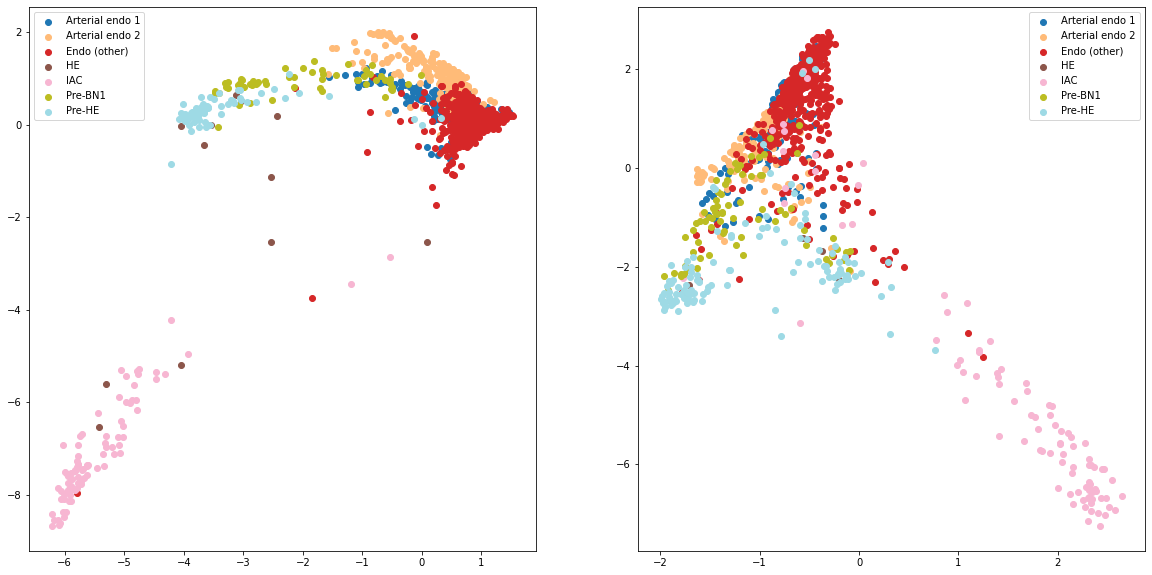

In [8]:
with torch.no_grad():
    for data in test_r1b1_loader:
        ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

    for data in test_r1b2_loader:
        ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

In [9]:
pre_train_disc(model_rna = ae1, model_atac = ae2, disc = disc, data_loader_rna = train_r1b1_loader, data_loader_atac = train_r1b2_loader, optimizer_D = optimizer_D, n_epochs = 101)

epoch:  0 Discriminator loss: 0.70362
epoch:  10 Discriminator loss: 0.66912
epoch:  20 Discriminator loss: 0.64160
epoch:  30 Discriminator loss: 0.60716
epoch:  40 Discriminator loss: 0.53330
epoch:  50 Discriminator loss: 0.48383
epoch:  60 Discriminator loss: 0.36901
epoch:  70 Discriminator loss: 0.28636
epoch:  80 Discriminator loss: 0.23713
epoch:  90 Discriminator loss: 0.19915
epoch:  100 Discriminator loss: 0.17231


In [11]:
# n_iter = 200 merge too good
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, P_rna= U_t1, P_atac= U_t2, n_epochs=201, n_iter=70, n_iter2 = 1, lamb_r_rna = 0, lamb_r_atac = 0, lamb_disc=1, dist_mode = "mse")

epoch:  0 RNA loss: 0.09041, RNA recon loss: 0.00000, RNA dist loss: 0.09041 ATAC loss: 0.06559, ATAC recon loss: 0.00000, ATAC dist loss: 0.06559 Discriminator loss: 0.59652
epoch:  10 RNA loss: 0.10467, RNA recon loss: 0.00000, RNA dist loss: 0.10467 ATAC loss: 0.08810, ATAC recon loss: 0.00000, ATAC dist loss: 0.08810 Discriminator loss: 0.61555
epoch:  20 RNA loss: 0.07876, RNA recon loss: 0.00000, RNA dist loss: 0.07876 ATAC loss: 0.11430, ATAC recon loss: 0.00000, ATAC dist loss: 0.11430 Discriminator loss: 0.61787
epoch:  30 RNA loss: 0.07379, RNA recon loss: 0.00000, RNA dist loss: 0.07379 ATAC loss: 0.07047, ATAC recon loss: 0.00000, ATAC dist loss: 0.07047 Discriminator loss: 0.62820
epoch:  40 RNA loss: 0.07190, RNA recon loss: 0.00000, RNA dist loss: 0.07190 ATAC loss: 0.05837, ATAC recon loss: 0.00000, ATAC dist loss: 0.05837 Discriminator loss: 0.59024
epoch:  50 RNA loss: 0.08602, RNA recon loss: 0.00000, RNA dist loss: 0.08602 ATAC loss: 0.07470, ATAC recon loss: 0.0000

In [14]:
# torch.save({
#     'ae1': ae1.state_dict(),
#     'optim_ae1': optimizer_rna.state_dict(),
#     'ae2': ae2.state_dict(),
#     'optim_ae2': optimizer_rna.state_dict(),
#     'disc': disc.state_dict(),
#     'optim_disc': optimizer_D.state_dict(),
#     'config1': symsim_r1b1_CONFIG,
#     'config2': symsim_r1b2_CONFIG,
#     'Diff1': Diff1,
#     'Diff2': Diff2
# }, './saved_model/endo_phate_new_withIAC3_pretrain.pt')

In [7]:
# state = torch.load('./saved_model/endo_phate_test.pt')

# ae1 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
#       ])).to(device)
# ae1.load_state_dict(state['ae1'])

# ae2 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
#       ])).to(device)
# ae2.load_state_dict(state['ae2'])

# disc = ae.discriminator().to(device)
# disc.load_state_dict(state['disc'])

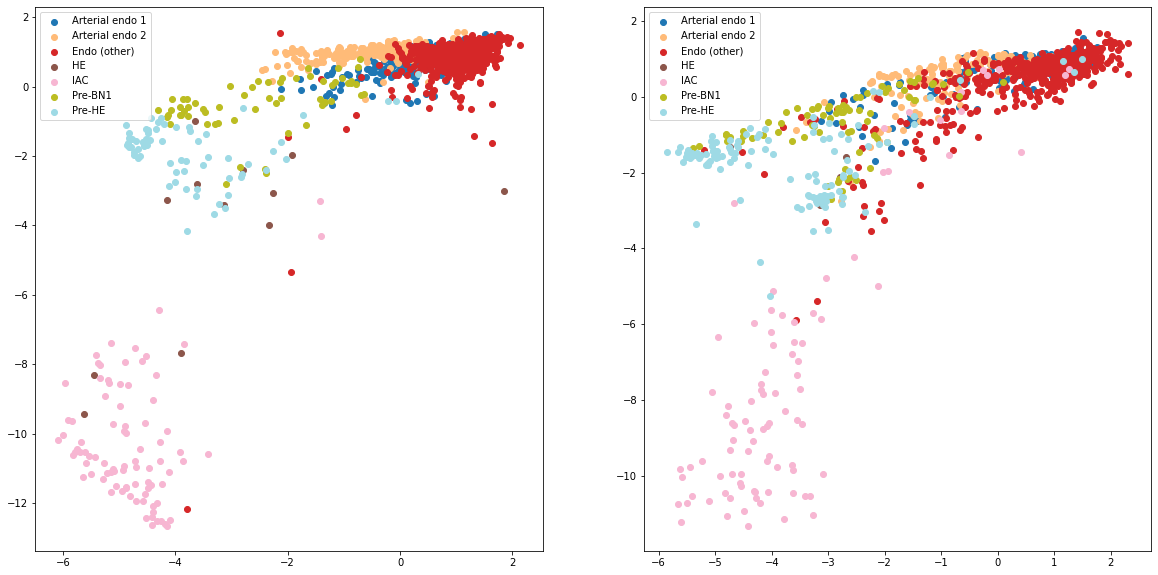

In [12]:
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

# plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "joint",save = "./result/endo/new/with_IAC/joint2.pdf")

plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

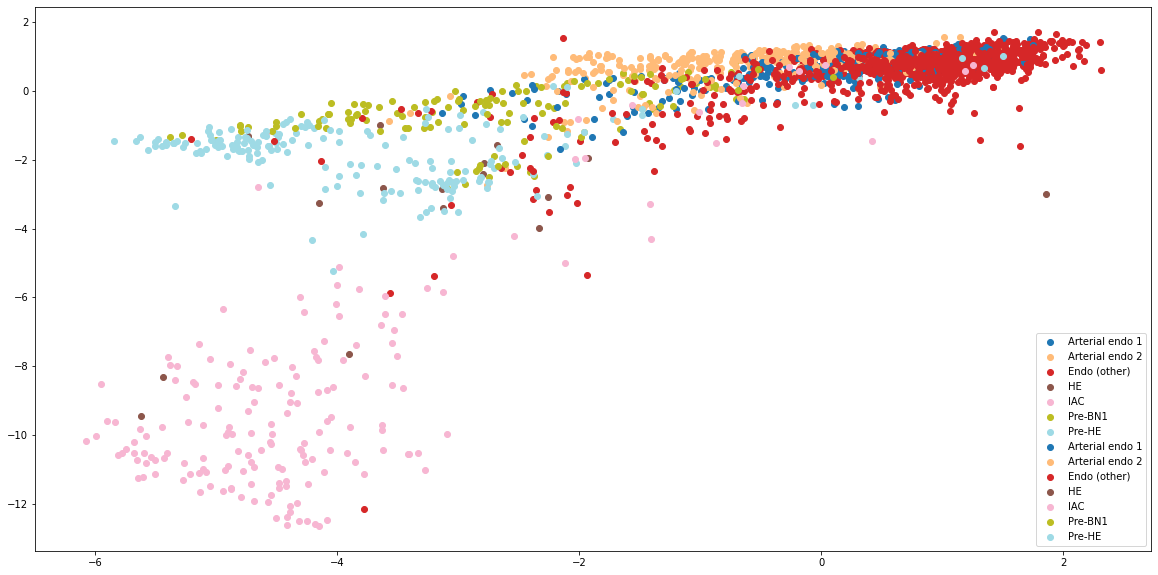

In [13]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "joint",save = None)

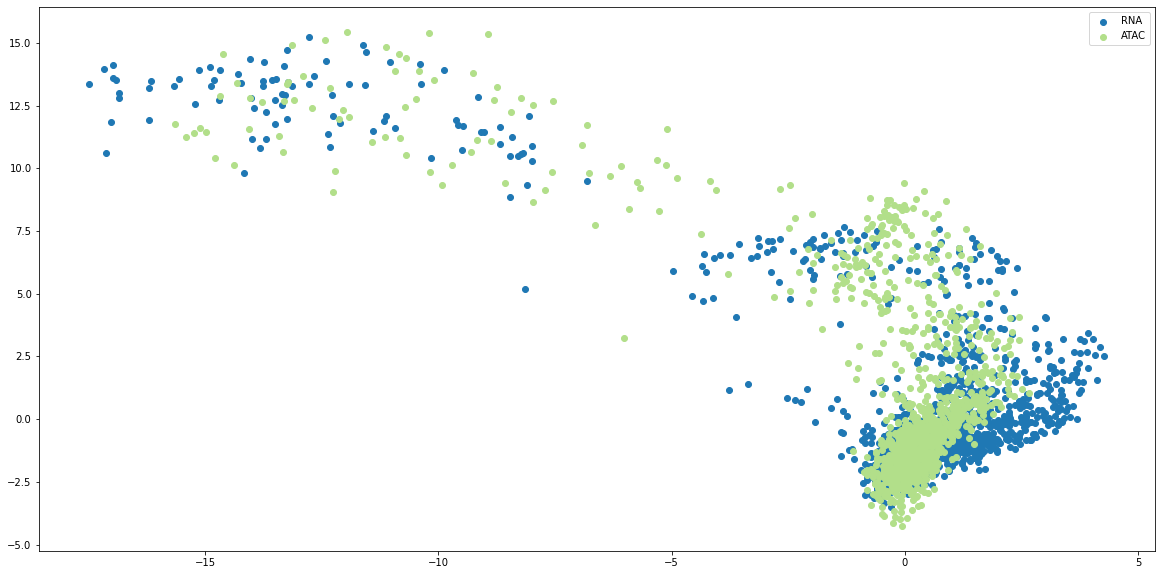

In [57]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "modality",save = 'result/endo/new/with_IAC/modality3.pdf')